In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('/content/drive/MyDrive/cv_lab3_input/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3)

In [3]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [4]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4184, 4165, 4207, 4198, 4154, 4251, 4242, 4204, 4184, 4211]
test groups: [1816, 1835, 1793, 1802, 1846, 1749, 1758, 1796, 1816, 1789]


In [5]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

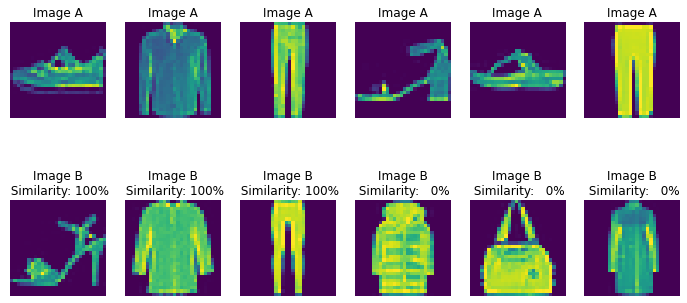

In [6]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation='linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [8]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [9]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [10]:
def find_simmilar(dataset, image, n_candidates=1024, finalists=4):
    candidates, preds = [], []
    for i in range(n_candidates):
        candidates.append(dataset[np.random.choice(range(len(dataset)))])
    compiled = [np.tile(image, (n_candidates, 1, 1, 1)), np.stack(candidates)]
    print(compiled[0].shape, compiled[1].shape)
    preds = similarity_model.predict(compiled).reshape(-1)
    print(preds.shape)
    top = np.argpartition(preds, -finalists)[-finalists:]
    for i in top:
        plt.imshow(candidates[i][:, :, 0])
        plt.show()
        print(preds[i])

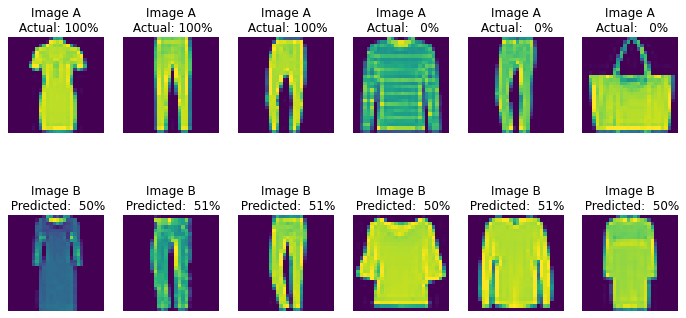

In [11]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [12]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 77s 135ms/step - loss: 0.6502 - mae: 0.4687 - val_loss: 0.5349 - val_mae: 0.3921
Epoch 2/10
500/500 [==============================] - 51s 102ms/step - loss: 0.5125 - mae: 0.3666 - val_loss: 0.4248 - val_mae: 0.2864
Epoch 3/10
500/500 [==============================] - 49s 99ms/step - loss: 0.4623 - mae: 0.3168 - val_loss: 0.3832 - val_mae: 0.2446
Epoch 4/10
500/500 [==============================] - 51s 102ms/step - loss: 0.4184 - mae: 0.2828 - val_loss: 0.3756 - val_mae: 0.2214
Epoch 5/10
500/500 [==============================] - 49s 99ms/step - loss: 0.4054 - mae: 0.2698 - val_loss: 0.3603 - val_mae: 0.2171
Epoch 6/10
500/500 [==============================] - 50s 100ms/step - loss: 0.4006 - mae: 0.2624 - val_loss: 0.3473 - val_mae: 0.2154
Epoch 7/10
500/500 [==============================] - 52s 103ms/step - loss: 0.3800 - mae: 0.2489 - val_loss: 0.3416 - val_mae: 0.2052
Epoch 8/10
500/500 [==============================] - 49s

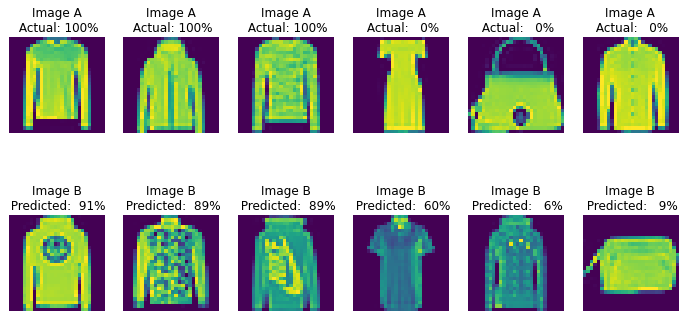

In [13]:
_ = show_model_output()

In [14]:
image = x_train[1345]

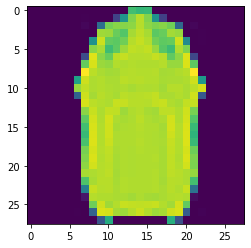

In [15]:
plt.imshow(image[:, :, 0])

(1024, 28, 28, 1) (1024, 28, 28, 1)
(1024,)


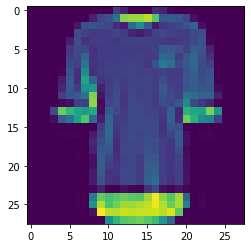

0.8522691


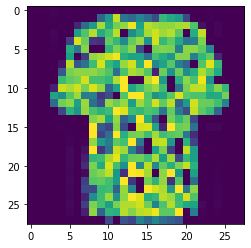

0.8523968


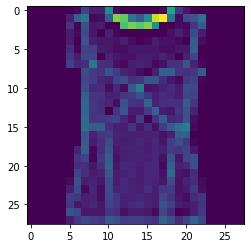

0.85358834


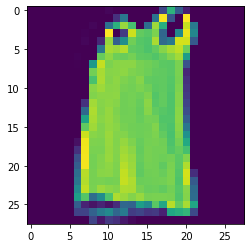

0.8562247


In [16]:
find_simmilar(x_train, image)

In [17]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

141/141 [==============================] - 9s 64ms/step


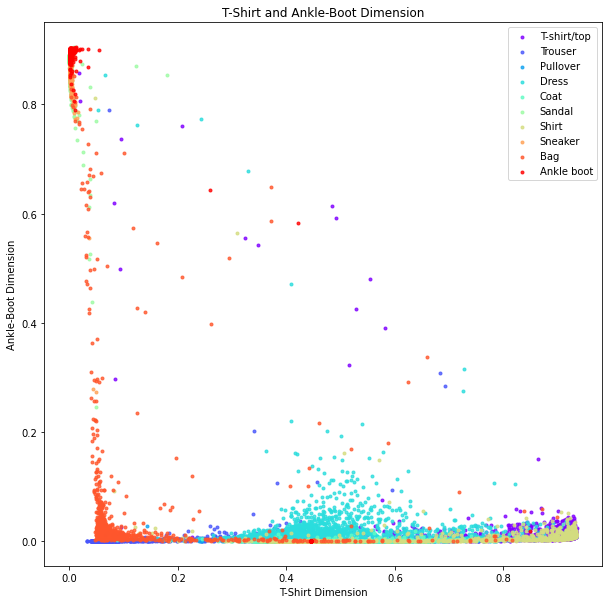

In [18]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth='1',
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [19]:
x_test_features = feature_model.predict(
    x_test,
    verbose=True,
    batch_size=128
)

141/141 [==============================] - 5s 35ms/step


In [20]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 18000 samples in 10.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sample 13000 / 18000
[t-SNE] Computed conditional probabilities for sample 14000 / 1800

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 80.7332306, gradient norm = 0.0019239 (50 iterations in 8.606s)
[t-SNE] Iteration 100: error = 78.8689728, gradient norm = 0.0010544 (50 iterations in 7.951s)
[t-SNE] Iteration 150: error = 77.9888458, gradient norm = 0.0007234 (50 iterations in 7.850s)
[t-SNE] Iteration 200: error = 77.4555817, gradient norm = 0.0005680 (50 iterations in 7.864s)
[t-SNE] Iteration 250: error = 77.0964355, gradient norm = 0.0004491 (50 iterations in 7.894s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.096436
[t-SNE] Iteration 300: error = 3.1668096, gradient norm = 0.0012053 (50 iterations in 8.032s)
[t-SNE] Iteration 350: error = 2.6499395, gradient norm = 0.0006455 (50 iterations in 7.995s)
[t-SNE] Iteration 400: error = 2.3302195, gradient norm = 0.0004088 (50 iterations in 7.877s)
[t-SNE] Iteration 450: error = 2.1267946, gradient norm = 0.0002864 (50 iterations in 8.020s)
[t-SNE] Iteration 500: error = 1.9862844, gradient norm = 0.0002153 (50 

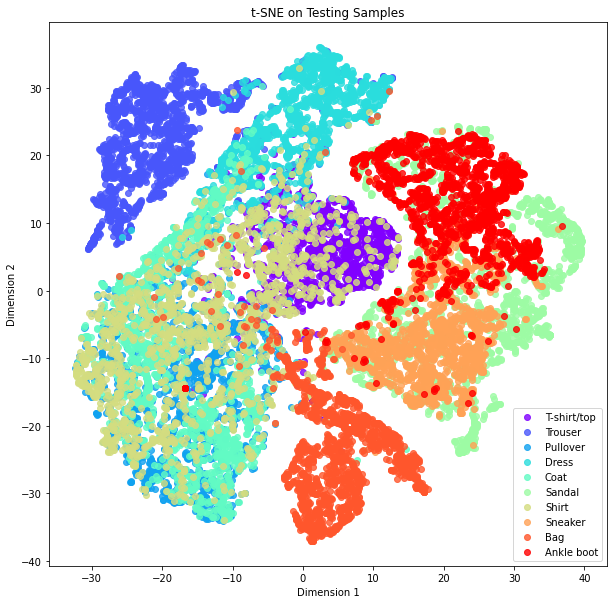

In [21]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth='1',
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)